In [1]:
from keras import applications, optimizers
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers.convolutional import Convolution2D
from keras import backend as K
import keras
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from img_loader import DatasetLoader
from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from sklearn.preprocessing import MinMaxScaler
import scipy.misc
from PIL import ImageEnhance, ImageOps
import cv2
import matplotlib.pyplot as pp
from keras.models import load_model, save_model
import random
from numpy import argmax
import tensorflow as tf

Using TensorFlow backend.


In [14]:
correct_preds = np.load('results_correct_prediction.npy')
wrong_preds = np.load('results_wrong_prediction.npy')

# Correct Predicitons

In [3]:
correct_preds.shape

(10222, 5, 2)

In [4]:
wrong_preds.shape

(178, 8, 2)

In [5]:
correct_preds[:, 2:].shape

(10222, 3, 2)

In [6]:
correct_preds[:, 2:, 1:]

array([[['0.6086244639829911'],
        ['0.6741604550340611'],
        ['0.5960959719230797']],

       [['0.7168559178006866'],
        ['0.800995615323544'],
        ['0.7127911150879972']],

       [['0.8174006478041715'],
        ['0.8686775049752646'],
        ['0.8102611933930685']],

       ..., 
       [['0.2451462507633796'],
        ['0.35860695888539657'],
        ['0.26564191242945895']],

       [['0.3305650552972705'],
        ['0.3922146556993603'],
        ['0.3587589040677532']],

       [['0.5222994633844229'],
        ['0.6823573256038512'],
        ['0.5479758790925087']]],
      dtype='<U22')

In [7]:
correct_preds[:, 2:, 1:][:,1][:,0]

array(['0.6741604550340611', '0.800995615323544', '0.8686775049752646',
       ..., '0.35860695888539657', '0.3922146556993603',
       '0.6823573256038512'],
      dtype='<U22')

In [8]:
unchanged = correct_preds[:, 2:, 1:][:,0][:,0].astype(np.float)
n10 = correct_preds[:, 2:, 1:][:,1][:,0].astype(np.float)
nmin = correct_preds[:, 2:, 1:][:,2][:,0].astype(np.float)

In [9]:
print('unchanged')
print('min', unchanged.min())
print('max', unchanged.max())
print('mean', unchanged.mean())
print('median', np.median(unchanged))

print('n01')
print('min', n10.min())
print('max', n10.max())
print('mean', n10.mean())
print('median', np.median(n10))

print('nmin')
print('min', nmin.min())
print('max', nmin.max())
print('mean', nmin.mean())
print('median', np.median(nmin))

unchanged
min 0.0
max 0.941213615425
mean 0.344595693933
median 0.327683817285
n01
min 0.0
max 0.955136974254
mean 0.419647000093
median 0.416357216897
nmin
min -1.31197765701
max 1.19654891921
mean 0.340991430248
median 0.330118494543


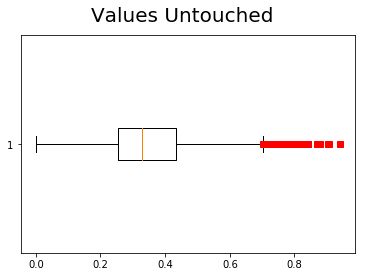

In [10]:
plt.figure().suptitle('Values Untouched', fontsize=20)
plt.boxplot(correct_preds[:, 2:, 1:][:,0][:,0].astype('float32'), 0, 'rs', 0)
plt.show()

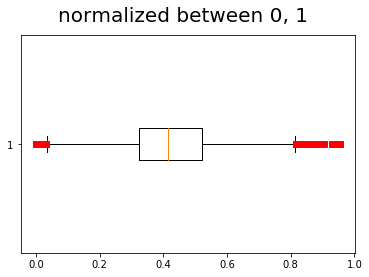

In [11]:
plt.figure().suptitle('normalized between 0, 1', fontsize=20)
plt.boxplot(correct_preds[:, 2:, 1:][:,1][:,0].astype('float32'), 0, 'rs', 0)
plt.show()

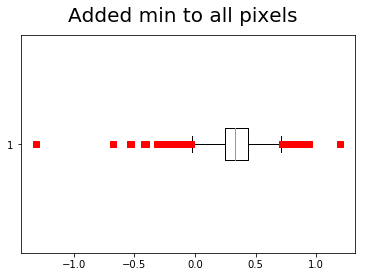

In [15]:
plt.figure().suptitle('Added min to all pixels', fontsize=20)
plt.boxplot(correct_preds[:, 2:, 1:][:,2][:,0].astype('float32'), 0, 'rs', 0)
plt.show()

# Wrong predicitons

In [16]:
wrong_preds.shape

(178, 8, 2)

In [26]:
wrong_preds[:, 2:, 1:][:,0][:,0].shape

(178,)

In [28]:
score_predicted = wrong_preds[:, 2:, 1:][:,0][:,0].astype('float32')
score_predicted_n01 = wrong_preds[:, 2:, 1:][:,1][:,0].astype('float32')
score_predicted_nmin = wrong_preds[:, 2:, 1:][:,2][:,0].astype('float32')
score_true_label = wrong_preds[:, 2:, 1:][:,3][:,0].astype('float32')
score_true_label_n01 = wrong_preds[:, 2:, 1:][:,4][:,0].astype('float32')
score_true_label_nmin = wrong_preds[:, 2:, 1:][:,5][:,0].astype('float32')

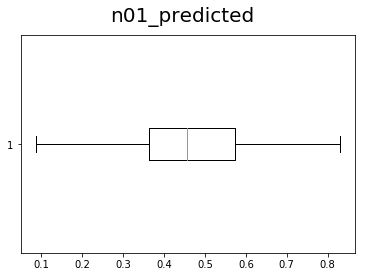

In [39]:
plt.figure().suptitle('n01_predicted', fontsize=20)
plt.boxplot(score_predicted_n01, 0, 'rs', 0)
plt.show()

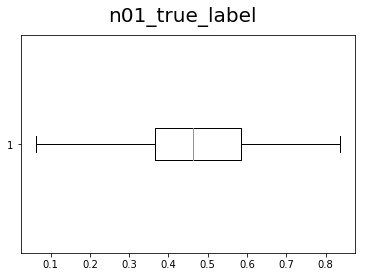

In [40]:
plt.figure().suptitle('n01_true_label', fontsize=20)
plt.boxplot(score_true_label_n01, 0, 'rs', 0)
plt.show()

In [41]:
print('unchanged')
print('min', score_predicted_n01.min())
print('max', score_predicted_n01.max())
print('mean', score_predicted_n01.mean())
print('median', np.median(score_predicted_n01))

print('n01')
print('min', score_true_label_n01.min())
print('max', score_true_label_n01.max())
print('mean', score_true_label_n01.mean())
print('median', np.median(score_true_label_n01))

unchanged
min 0.086623
max 0.83035
mean 0.464236
median 0.456797
n01
min 0.0623723
max 0.836771
mean 0.471734
median 0.461431


Okay it does not tell much here let's compare the two scores...

In [46]:
print('score_predicted_n01', score_predicted_n01[0])
print('score_true_label_n01', score_true_label_n01[0])
print('===================')
print('score_predicted_n01', score_predicted_n01[1])
print('score_true_label_n01', score_true_label_n01[1])

score_predicted_n01 0.20908
score_true_label_n01 0.215158
score_predicted_n01 0.404313
score_true_label_n01 0.547835


So the CCN is looking with a larger error rate at the correct class. So when a CNN is making mistakes it looks outside of the leaf. Let's verify this by plotting our values.

In [60]:
score_predicted = sorted(score_predicted)
score_true_label = sorted(score_true_label)

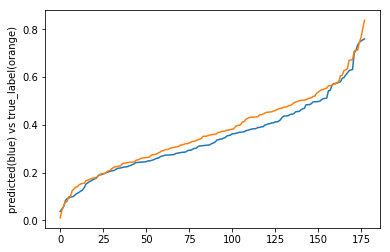

In [61]:
plt.plot(range(0, len(score_predicted)), score_predicted)
plt.plot(range(0, len(score_true_label)), score_true_label)
plt.ylabel('predicted(blue) vs true_label(orange)')
plt.show()

In [58]:
score_predicted_n01 = sorted(score_predicted_n01)
score_true_label_n01 = sorted(score_true_label_n01)

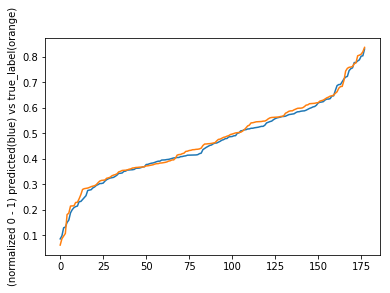

In [59]:
plt.plot(range(0, len(score_predicted_n01)), score_predicted_n01)
plt.plot(range(0, len(score_true_label_n01)), score_true_label_n01)
plt.ylabel('(normalized 0 - 1) predicted(blue) vs true_label(orange)')
plt.show()